주차 수요 예측 AI 경진대회 https://dacon.io/competitions/official/235745/overview/description

목표 : 🏠 유형별 임대주택 설계 시 단지 내 적정 🅿️ 주차 수요를 예측 (차량등록수)

<br>


In [13]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# 데이터 분석 및 전처리


## Dataset Load

In [14]:
train = pd.read_csv('data/train.csv', encoding='utf-8')
test = pd.read_csv('data/test.csv', encoding='utf-8')

<br>

## 데이터 분석

### 기본 시각화

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc

import seaborn as sns

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import missingno as msno

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 15 columns):
단지코드                            2952 non-null object
총세대수                            2952 non-null int64
임대건물구분                          2952 non-null object
지역                              2952 non-null object
공급유형                            2952 non-null object
전용면적                            2952 non-null float64
전용면적별세대수                        2952 non-null int64
공가수                             2952 non-null float64
자격유형                            2952 non-null object
임대보증금                           2383 non-null object
임대료                             2383 non-null object
도보 10분거리 내 지하철역 수(환승노선 수 반영)    2741 non-null float64
도보 10분거리 내 버스정류장 수              2948 non-null float64
단지내주차면수                         2952 non-null float64
등록차량수                           2952 non-null float64
dtypes: float64(6), int64(2), object(7)
memory usage: 346.0+ KB


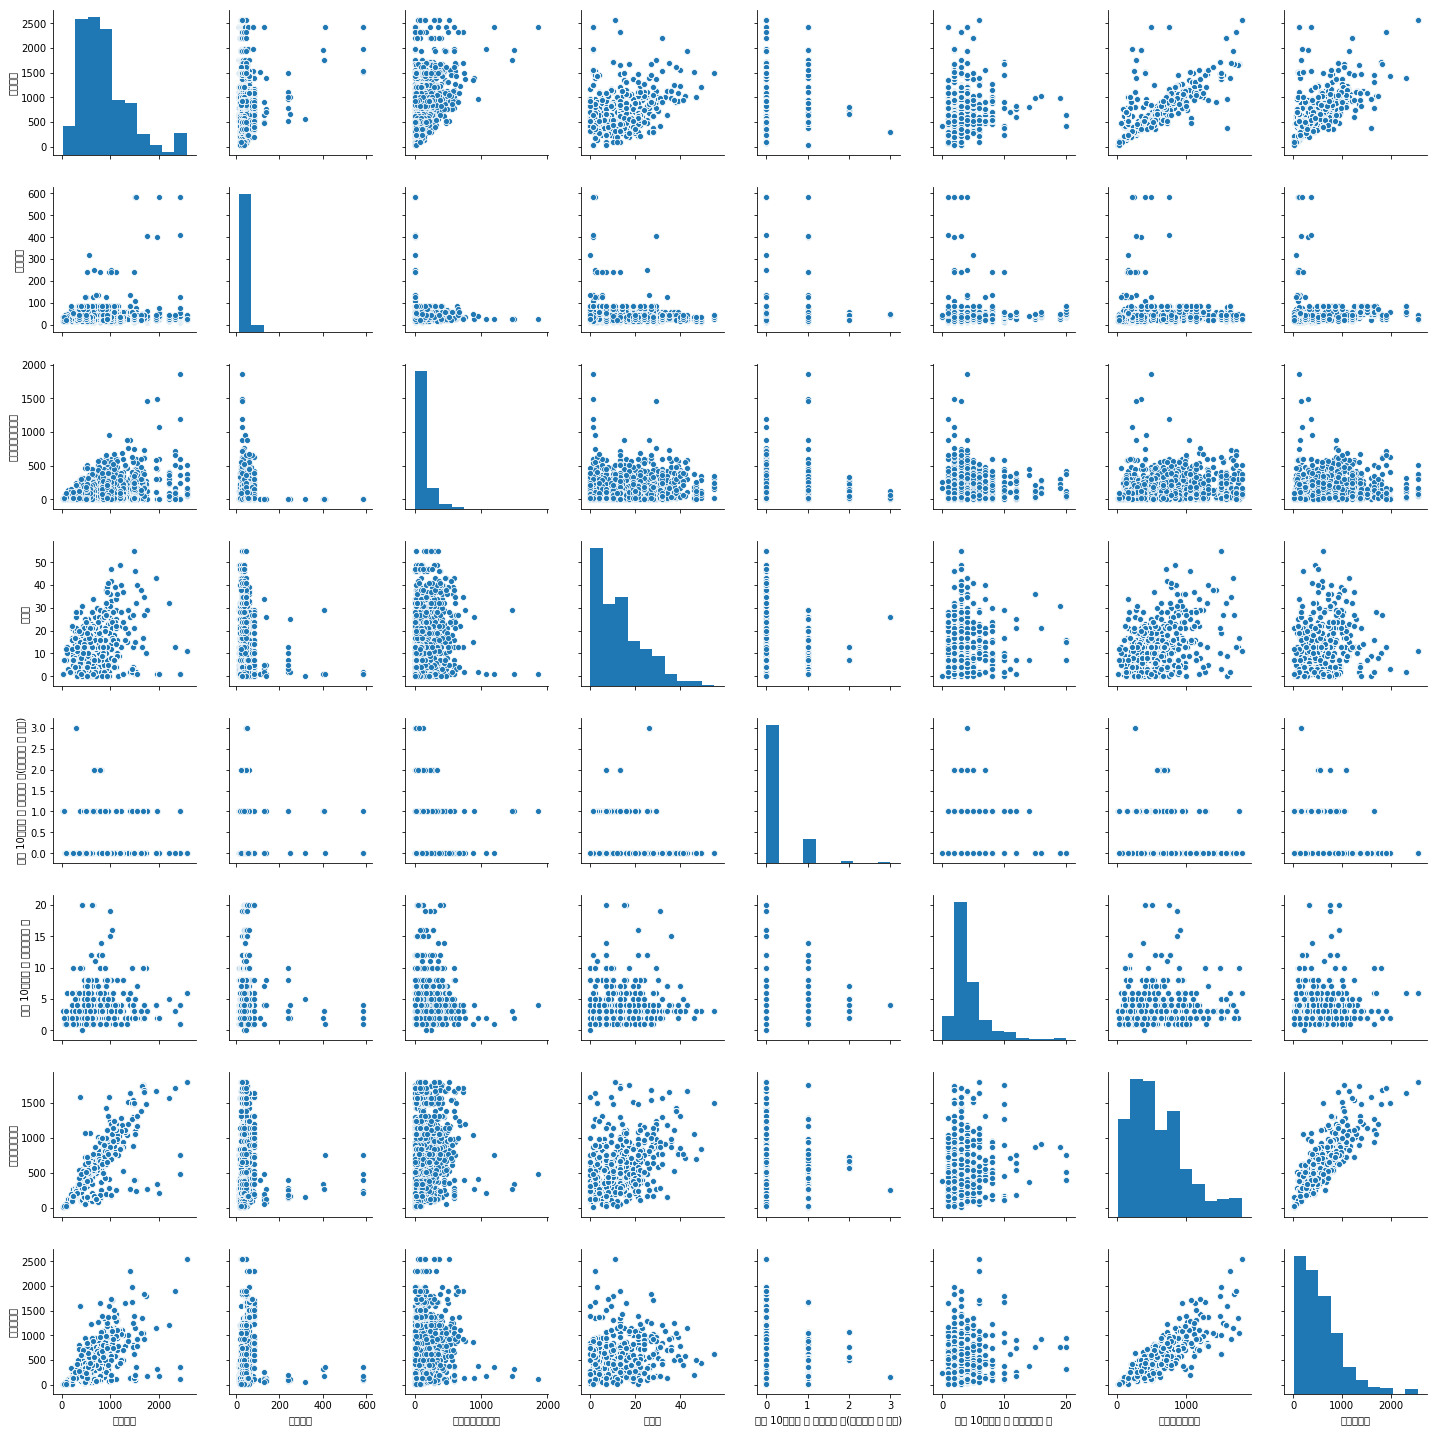

In [17]:
sns.pairplot(train)

### 오류 확인

1. 전용면적별 세대수 합계와 총세대수가 일치하지 않는 경우  

 - (오류 내용) 제공한 데이터(트레인 및 테스트) 중 총 58개 단지에서 전용면적별 세대수 합계가 총세대수보다 적은 경우가 발생하였습니다. 

 - (분포 현황) 차이는 최소 1세대부터 최대 452세대까지이며, 그 가운데 48개 단지(83%) 는 차이가 1~14세대, 나머지 10개 단지(17%) 는 차이가 94~452세대 사이에 분포합니다. 

 - (발생 원인) 차이는 분양상가 또는 분양아파트가 임대단지 안에 혼합되어 발생한 것으로, 분양 완료된 상가 ․ 아파트는 관리대상에서 제외되어 전용면적별 세대수에서는 포함되지 않았으나 총세대수에는 포함되었습니다. 

 - (관련 데이터) 차이가 14세대 이하인 48개 단지는 분양상가, 차이가 94~452세대에 분포하는 10개 단지는 분양아파트 혼합단지인 것으로 확인되며, 아래 10개 단지의 코드를 확인하셔서 데이터 분석에 참고해주시기 바랍니다.

※ 차이가 14세대 이하인 48개 단지 : 하단 별첨 참조
['C1925', 'C1312', 'C2013', 'C1424', 'C2520', 'C2319', 'C1850', 'C1068', 'C2644', 'C2156', C2453', 'C1910', 'C2139', 'C2508', 'C1695', 'C2556', 'C2362', 'C2568', 'C2245', 'C2549', 'C1584', 'C2298', 'C2225', 'C1218', 'C1970', C1732', 'C2433', 'C1894', 'C1156', 'C2142', 'C2186', 'C2411', 'C1812', 'C1030', 'C1749', 'C1349', 'C2043', 'C1229', 'C2363', 'C1414', C2174', 'C2404', 'C1683', 'C1038', 'C2456', 'C1266', 'C1267', 'C2189']

※ 차이가 94~452세대인 10개 단지(크기순) : ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804’]

2. 동일한 단지에 단지코드가 2개로 부여된 경우  

 - (오류 내용) 동일한 단지임에도 불구하고 코드가 2개로 부여되어 별개의 단지로 인식되도록 데이터가 제공되었고, 그로 인해 주차면수는 2개 단지에 합산값으로 기재되었고 총세대수는 2개 단지에 각각 계상된 형태로 나타났습니다.

 - (발생 원인) 1번과 마찬가지로 분양과 임대가 혼합된 유형의 단지임으로 인해 발생한 오류이나 1번에서는 분양세대에 단지코드가 부여되지 않고 전용면적별 세대수에서 빠져있는 반면, 2번에서는 분양세대에도 단지코드가 부여되어 별개의 단지인 것처럼 인식되었습니다. 

 - (참고 사항) 주차면수는 하나의 단지임을 전제로 산정된 것이고 총세대수는 두 개 단지의 합계입니다. 다만 등록차량대수는 ['C2085', 'C1397'] 단지의 경우 동일 수치, ['C2431', 'C1649']] 단지의 경우 두 개 단지 합계입니다. 
 ![image.png](image/다운로드.png)



 - (관련 데이터) 아래와 같이 총 3개 단지 6개 코드에서 같은 유형의 오류가 확인되었습니다.  

※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍) : ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675'] 

 - C2675 단지는 테스트셋, 나머지는 트레인셋 입니다.

 

3. 단지코드 등 기입 실수로 데이터 정제 과정에서 매칭 오류 발생  

 - (오류 내용) 단지코드 등 기입 실수로 총세대수가 주차면수에 비해 과하게 많거나 적은 경우가 발생하였고, 점검 결과 일부 데이터의 단지코드, 총세대수, 주차면수 등에서 오류가 검출되었습니다.

 - (발생 원인) 원천데이터 수집 과정에서 단지 코드 등이 잘못 기입되었고 이를 인지하지 못한 채 데이터 정제를 하여 오류가 발생하였습니다.

 - (관련 데이터) 아래와 같이 총 9개 단지에서 같은 문제가 확인되었습니다. 

※ 실수가 발생한 단지 코드 (9개 단지) : ['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']

 - C2335, C1327 단지는 테스트셋, 나머지는 트레인셋 입니다.




4. 오류 데이터 처리 방안

 - 제공한 데이터상에 문제점이 발견되었으나 대회 중반에 들어선 시점에서 오류를 수정하여 재배포할 경우 혼란이 가중될 것이 우려되어 데이터 수정/재배포는 없을 예정입니다.

 - 1번 오류의 경우 해당 사실을 감안하여 분석을 진행해 주시기 바라며, 2, 3번 오류의 경우에는 문제가 된 단지들을 트레인셋에서 제외하기를 권장드리고, 테스트셋에서는 평가 시 제외하고자 합니다.

 - 테스트셋에서 평가 제외되는 데이터는 'C2675'(2번 사항에 해당), 'C2335', 'C1327'(3번 사항에 해당) 3개 단지입니다.

 - 제출 양식은 변경되지 않으니 기존 제출 양식에 따라 제출 부탁드립니다.('C2675', 'C2335', 'C1327' 단지 예측 결과는 평가되지 않습니다.)

 - 이번에 검출된 오류 외 혹시 모를 추가적인 오류발생을 대비해 데이터 검증을 계속 진행중이며 문제 발견시 공지 및 안내해드리겠습니다.

### 결측치 확인

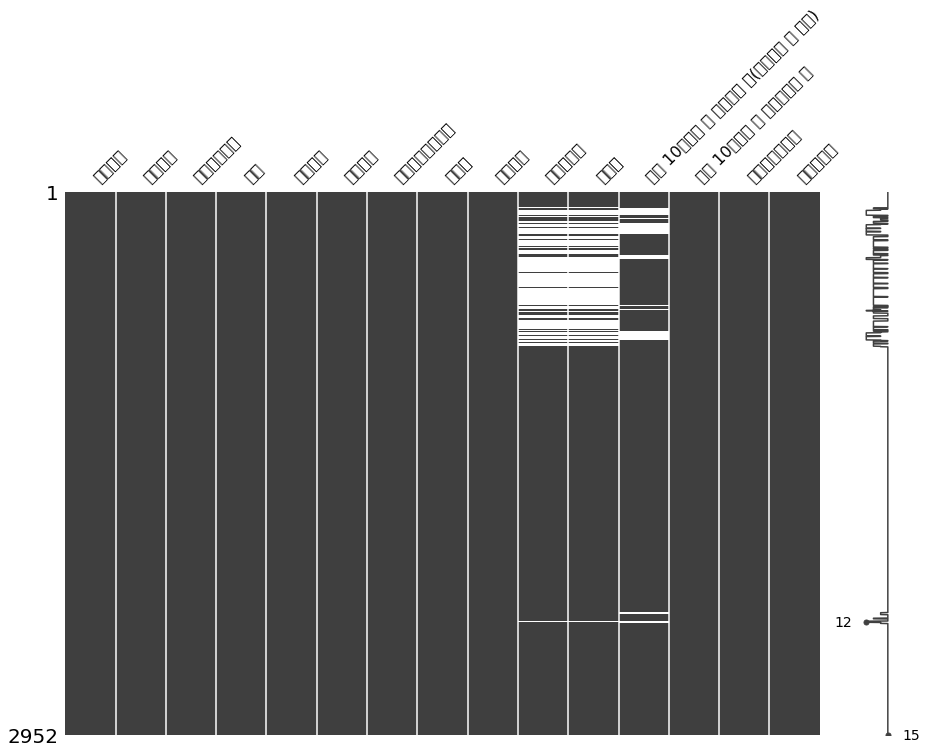

In [18]:
msno.matrix(train, figsize=(15,10))

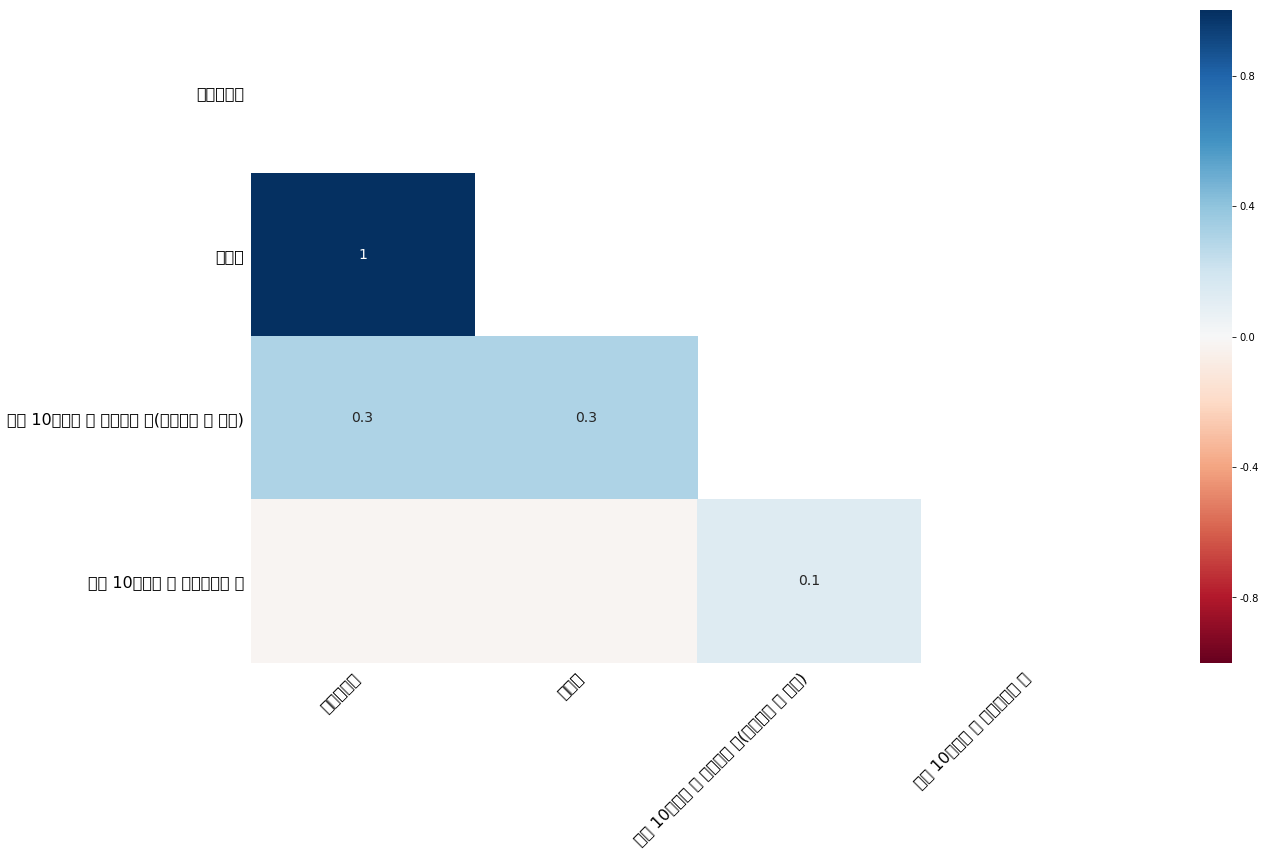

In [19]:
msno.heatmap(train)

In [20]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
등록차량수                             0
dtype: int64

<br>

## 데이터 전처리

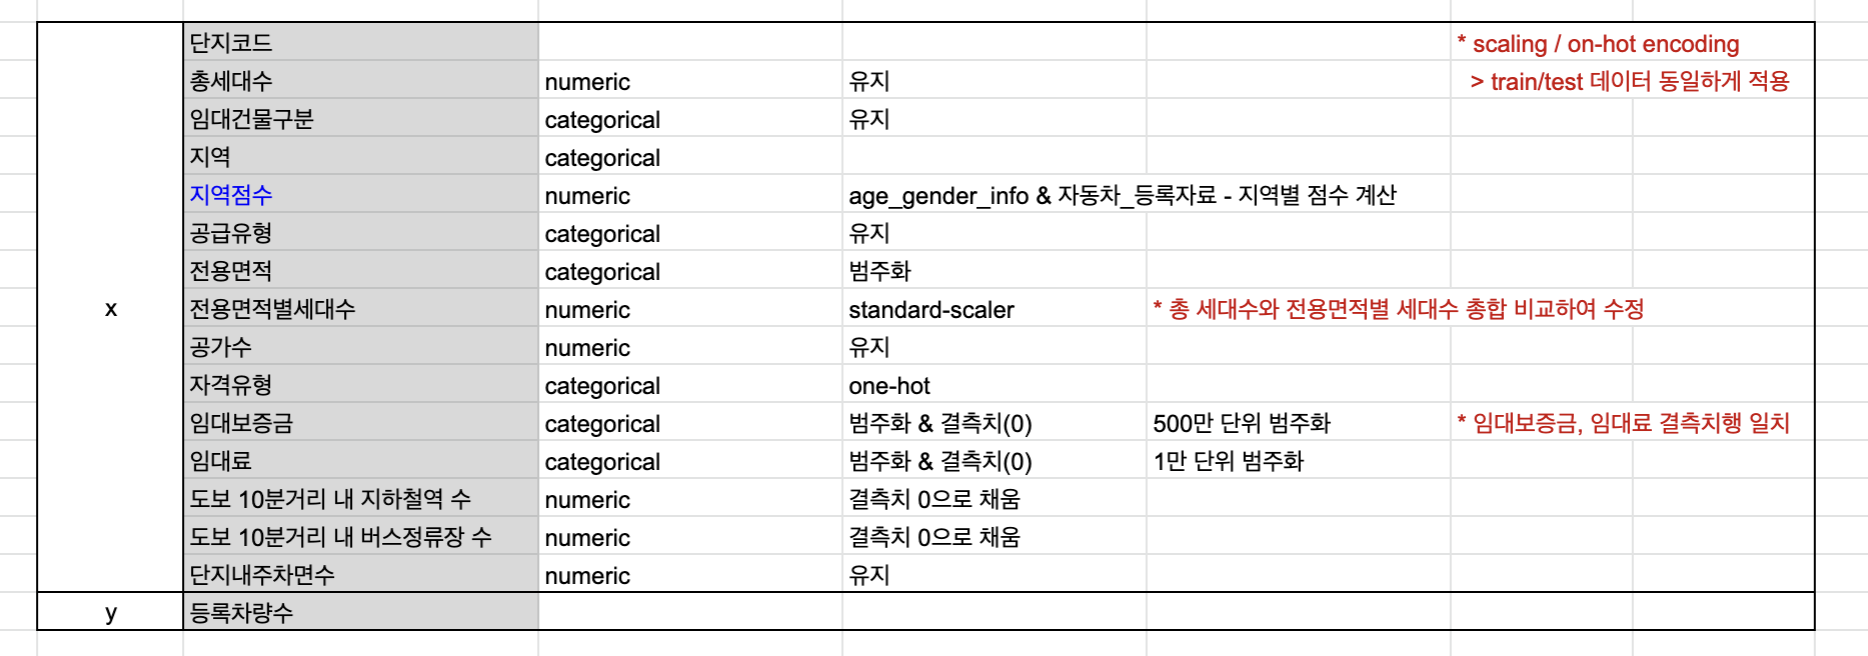

### 오류 해결
#### 2번과 3번 오류가 있는 행
해당 행 삭제

In [21]:
# ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675']

train = train[train['단지코드']!='C2085']
train = train[train['단지코드']!='C1397']
train = train[train['단지코드']!='C2431']
train = train[train['단지코드']!='C1649']
train = train[train['단지코드']!='C1036']
train = train[train['단지코드']!='C2675']
train = train.reset_index()

del train['index']
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


#### 총세대수 (전용면적별 세대수 합과 총 세대수 불일치 문제)
총세대수와 전용면적별 세대수 총합 사이 차이를 전용면적별 세대수 기준 비중을 나눠 전용면적별 세대수에 포함시킴으로써 총합을 맞춤

In [22]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0


In [23]:
# 전용면적별 세대수 다시 계산
def get_number_of_households(df):
    df['총세대수(new)'] = 0

    for i, code in enumerate(df['단지코드']):
        df['총세대수(new)'][i] = df[df['단지코드'] == code]['전용면적별세대수'].sum()

    df['총세대수 차이'] = df['총세대수'] - df['총세대수(new)']

    df['전용면적별세대수'] = round(df['전용면적별세대수'] + (df['전용면적별세대수'] / df['총세대수(new)']) * df['총세대수 차이'], 3)

    del df['총세대수(new)']
    del df['총세대수 차이']

    return df

In [ ]:
train = get_number_of_households(train)
train.head()

<br>

### 결측치 제거

#### 임대보증금

In [ ]:
train[(train['임대보증금'].isnull()) | (train['임대보증금'] == '-')].head()

In [ ]:
def deal_missing_value1(df):
    df['임대보증금'].fillna(0, inplace=True)
    df['임대보증금'].replace('-', 0, inplace=True)
    return df

train = deal_missing_value1(train)
train[(train['임대보증금'].isnull()) | (train['임대보증금'] == '-')].head()

#### 임대료

In [ ]:
train[(train['임대료'].isnull()) | (train['임대료'] == '-')].head()

In [ ]:
def deal_missing_value2(df):
    df['임대료'].fillna(0, inplace=True)
    df['임대료'].replace('-', 0, inplace=True)
    return df

In [ ]:
train = deal_missing_value2(train)
train[(train['임대료'].isnull()) | (train['임대료'] == '-')].head()

#### 도보 10분거리 내 지하철역 수(환승노선 수 반영)

In [ ]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

In [ ]:
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0, inplace=True)
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

#### 자격유형 (test data 결측치 처리)

In [ ]:
# 공급유형, 자격유형 관계
pd.crosstab(train['공급유형'], train['자격유형'] , margins = True).style.background_gradient(cmap = 'coolwarm')

<br>

### 추가 자료

#### 2020년_12월_자동차_등록자료_통계.xlsx

https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1257

지역별 인구수와 자동차 등록 통계자료 이용하여 지역 점수 부과

In [ ]:
# 추가자료 - 2020년 12월 자동차 등록 통계자료
car = pd.read_excel('data/자동차_등록자료_통계.xlsx', index_col='구분')
car = car.iloc[:,:16]
car.head()

In [ ]:
# dacon 제공자료 - 지역별 & 성별 & 연령별 인구 데이터
age = pd.read_csv('data/age_gender_info.csv', encoding='utf-8',index_col = '지역')
age.head()

In [19]:
temp_lst = set()

for x in car.columns:
    temp_lst.add(x)
    
temp_lst = list(temp_lst)
temp_lst.sort()

np.score = np.array(age.sort_index()) * np.array(car.transpose().sort_index())
df_score = pd.DataFrame(np.score)
df_score['지역'] = temp_lst
df_score['지역점수'] = df_score.transpose().iloc[:22,:].sum().transpose()

In [20]:
df_score[['지역', '지역점수', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]].head()

,지역,지역점수,0,1,2,3,4,5,6,7,8,9
0,강원도,39002.359527,0.0,6.136306,847.770475,3568.594182,7397.369872,9946.471557,8153.249392,2236.683712,644.506832,37.945310
1,경기도,283421.383725,0.0,89.918461,6062.001568,35989.495367,64639.537128,67076.541863,52536.391090,13044.629166,2808.260173,225.504806
2,경상남도,84581.674602,0.0,16.275946,1516.758566,8702.184213,18865.130498,24196.531673,14655.487171,4199.754263,791.114343,57.054064
3,경상북도,71541.59246,0.0,7.601555,1345.025226,7464.625421,13681.377767,20720.687138,13775.405136,4212.530728,1108.824945,68.764615
4,광주광역시,33314.61967,0.0,6.083660,731.756397,3443.511987,7757.868734,8617.935080,5314.768932,1563.764178,280.499010,26.605597


In [21]:
df_score = df_score[['지역', '지역점수']]

train = pd.merge(train, df_score, how='left', on='지역')
test = pd.merge(test, df_score, how='left', on='지역')

In [22]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,지역점수
0,C2483,900,아파트,경상북도,국민임대,39.72,134.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,71541.59246
1,C2483,900,아파트,경상북도,국민임대,39.72,15.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,71541.59246
2,C2483,900,아파트,경상북도,국민임대,51.93,385.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246
3,C2483,900,아파트,경상북도,국민임대,51.93,15.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246
4,C2483,900,아파트,경상북도,국민임대,51.93,41.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246


<br>

### 데이터 범주화

#### 전용면적

#### 임대보증금
500만 단위 범주화

#### 임대료
1만 단위 범주화

<br>

## test 데이터 전처리

In [23]:
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              2
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     42
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
지역점수                              0
dtype: int64

In [24]:
# 전용면적별 세대수 계산
test = get_number_of_households(test) 
test.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수
0,C1072,754,아파트,경기도,국민임대,39.79,116.0,14.0,H,22830000,189840,0.0,2.0,683.0,283421.383725
1,C1072,754,아파트,경기도,국민임대,46.81,30.0,14.0,A,36048000,249930,0.0,2.0,683.0,283421.383725
2,C1072,754,아파트,경기도,국민임대,46.90,112.0,14.0,H,36048000,249930,0.0,2.0,683.0,283421.383725


In [25]:
# 임대보증금
test = deal_missing_value1(test)
test[(test['임대보증금'].isnull()) | (test['임대보증금'] == '-')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수


In [26]:
# 임대료
test = deal_missing_value2(test)
test[(test['임대료'].isnull()) | (test['임대료'] == '-')].head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수


In [27]:
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0, inplace=True)
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull().sum()

0

In [28]:
# 자격유형
# 임시 - 삭제
test = test[~test['자격유형'].isnull()]

In [29]:
test.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수
0,C1072,754,아파트,경기도,국민임대,39.79,116.0,14.0,H,22830000,189840,0.0,2.0,683.0,283421.383725
1,C1072,754,아파트,경기도,국민임대,46.81,30.0,14.0,A,36048000,249930,0.0,2.0,683.0,283421.383725
2,C1072,754,아파트,경기도,국민임대,46.90,112.0,14.0,H,36048000,249930,0.0,2.0,683.0,283421.383725
3,C1072,754,아파트,경기도,국민임대,46.90,120.0,14.0,H,36048000,249930,0.0,2.0,683.0,283421.383725
4,C1072,754,아파트,경기도,국민임대,51.46,60.0,14.0,H,43497000,296780,0.0,2.0,683.0,283421.383725


In [30]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수,지역점수
0,C2483,900,아파트,경상북도,국민임대,39.72,134.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,71541.59246
1,C2483,900,아파트,경상북도,국민임대,39.72,15.0,38.0,A,15667000,103680,0.0,3.0,1425.0,1015.0,71541.59246
2,C2483,900,아파트,경상북도,국민임대,51.93,385.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246
3,C2483,900,아파트,경상북도,국민임대,51.93,15.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246
4,C2483,900,아파트,경상북도,국민임대,51.93,41.0,38.0,A,27304000,184330,0.0,3.0,1425.0,1015.0,71541.59246


<br>

# Machine Learning

## x / y split

In [31]:
train.columns

Index(['단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
       '자격유형', '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수', '지역점수'],
      dtype='object')

In [32]:
y_train = train[['등록차량수']]
del train['등록차량수']

x_train = train.iloc[:, 1:]
x_test = test.iloc[:, 1:]

## Pipeline & LinearRegression

In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression

one-hot vectorize

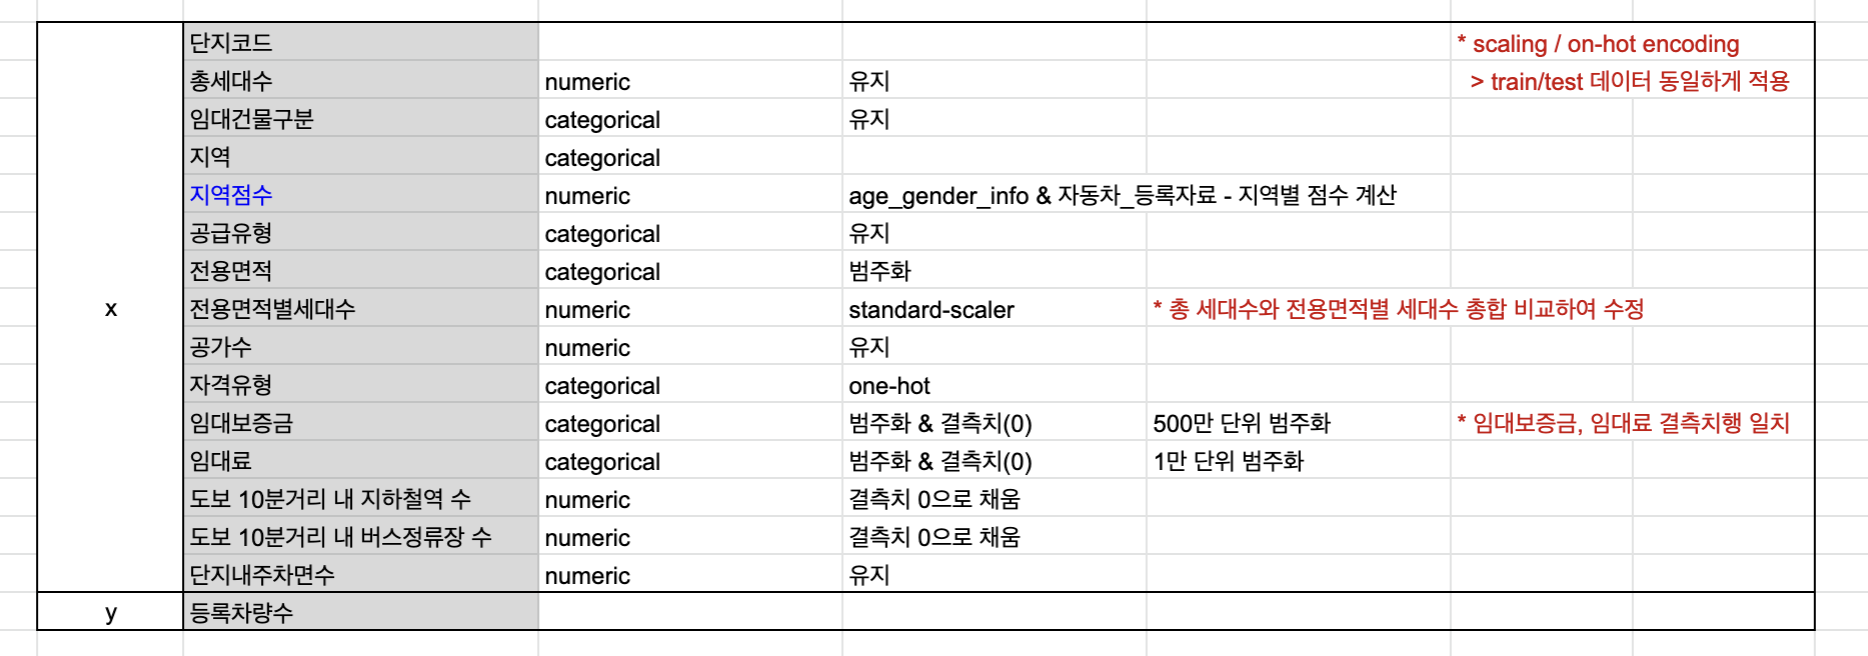

In [34]:
x_train.head(1)

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,지역점수
0,900,아파트,경상북도,국민임대,39.72,134.0,38.0,A,15667000,103680,0.0,3.0,1425.0,71541.59246


In [35]:
# numeric_features = ['총세대수', '전용면적', '전용면적별세대수', '공가수', '임대보증금', '임대료','도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '지역점수']
numeric_features = ['총세대수','전용면적별세대수','공가수'
               ,'도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수','단지내주차면수','지역점수'
               ,'전용면적', '임대보증금', '임대료']

numeric_transformer = StandardScaler()

categorical_features = ['임대건물구분', '공급유형', '자격유형', '지역']
categorical_transformer = OneHotEncoder(categories='auto',sparse = False))

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
preprocessor_pipe.fit(train)


In [ ]:
x_train= pd.DataFrame(preprocessor_pipe.transform(train))
x_test = pd.DataFrame(preprocessor_pipe.transform(test))

In [ ]:
model = LinearRegression()


In [36]:
model.fit(x_train, y_train)
train_pred = model.predict(x_train)

accuracy = model.score(x_train, y_train)
print("model score:", round(accuracy, 4))

model score: 0.8307


In [37]:
y_train

0       1015.0
1       1015.0
2       1015.0
3       1015.0
4       1015.0
         ...  
2920     146.0
2921     146.0
2922     146.0
2923     146.0
2924     146.0
Name: 등록차량수, Length: 2925, dtype: float64

In [38]:
train_pred

array([1212.03527573, 1206.95149868, 1231.66237899, ...,  219.81291361,
        223.217451  ,  220.07267898])

### Dacon 답안 제출

In [60]:
answer = pd.read_csv('data/sample_submission.csv')
answer.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


# Deep Learning

In [39]:
import tensorflow as tf
from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [42]:
import os
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [43]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=53, units=64, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
model.add(layers.Activation('elu')) # elu, relu / layers.ELU, layers.LeakyReLU

model.add(layers.Dense(units=64, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

# dropout
model.add(layers.Dropout(rate=0.4)) 

model.add(layers.Dense(units=1, activation=None))

In [44]:
model.compile(optimizer=optimizers.Adam(),
              loss=losses.mean_absolute_error, # MAE / mean_absolute_error
              metrics=[metrics.mae])

In [60]:
history = model.fit(x_train, y_train, batch_size=100, epochs=1000, validation_split=0.3, verbose=0)

In [ ]:
# result = model.evaluate(test_data, test_label)

# print('loss (mean_squared_error) :', result[0])

In [ ]:
# history.history.keys()

In [ ]:
loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']

x_len = np.arange(len(loss))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MAE)')
plt.show()

In [ ]:
model.predict(test_data)[:10]

# 최종 비교